# These are the Cartography visuals.

# To Do:
- add snakemake commands instead of explicit paths once main snakefile is updated
- add genetic KDE to full plot (create using the scripts)

# Imports Section 

In [2]:
import sys
sys.path.append("../notebooks/")

In [3]:
import altair as alt
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
#from reportlab.graphics import renderPDF
import seaborn as sns
#from svglib.svglib import svg2rlg

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [ ]:
try: 
    snakemake.input.node_df
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

## Pathogen-specific variables

Consider consolidating these into a single configuration file that can be passed to the notebook as a command line argument for more scriptable generation of these figures.

# Flu Specific Variables

In [7]:
try:
    node_df = snakemake.input.node_df

    pca_df = snakemake.input.pca_df
    explained_variance_pca = snakemake.input.explained_variance_pca

    mds_df = snakemake.input.mds_df

    #Scatterplot:
    scatterplot_pca = snakemake.input.scatterplot_pca
    scatterplot_pca_metadata = snakemake.input.scatterplot_pca_metadata

    scatterplot_mds = snakemake.input.scatterplot_mds
    scatterplot_mds_metadata = snakemake.input.scatterplot_mds_metadata

    scatterplot_tsne = snakemake.input.scatterplot_tsne
    scatterplot_tsne_metadata = snakemake.input.scatterplot_tsne_metadata

    scatterplot_umap = snakemake.input.scatterplot_umap
    scatterplot_umap_metadata = snakemake.input.scatterplot_umap_metadata

    #KDE Density:
    KDE_pca = snakemake.input.KDE_pca
    KDE_pca_metadata = snakemake.input.KDE_pca_metadata

    KDE_mds = snakemake.input.KDE_mds
    KDE_mds_metadata = snakemake.input.KDE_mds_metadata

    KDE_tsne = snakemake.input.KDE_tsne
    KDE_tsne_metadata = snakemake.input.KDE_tsne_metadata

    KDE_umap = snakemake.input.KDE_umap
    KDE_umap_metadata = snakemake.input.KDE_umap_metadata
    
    KDE_genetic = snakemake.input.KDE_genetic
    KDE_genetic_metadata = snakemake.input.KDE_genetic_metadata
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


In [11]:
clades_to_plot = ['3c3.A', 'A3', 'A2/re', 'A2', 'A1b/135N', 'A1b/131K', 'A1b/94N', 'A1b/131K', 'A1b/197R', 'A1b/135K', 'A1b/137F', 'A1b/186D']

# Reading in all the data from the scripts

In [75]:
import os

os.getcwd()

'/mnt/c/Work/BedfordProjects/cartography/seasonal-flu-nextstrain'

In [5]:
node_df = pd.read_csv(node_df, sep="\t")

In [6]:
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)

In [7]:
node_df.head()

strain     date  pca1  pca2   mds1   mds2  tsne_x  tsne_y  \
0      A/Chungbuk/107/2016  2016.05 -1.42  5.06  10.81  -4.59   48.66   -2.59   
1  A/MUWRP-Uganda/579/2016  2016.67 -1.03  5.42  19.97   3.88   48.33   -2.50   
2       A/Shiraz/1011/2015  2015.89 -1.32  5.35  11.78  -5.42   47.27   -2.32   
3       A/Shiraz/1019/2016  2016.00 -1.46  5.34  14.05 -11.67   47.34   -2.33   
4       A/Shiraz/1020/2016  2016.02 -1.46  5.33  10.98  -1.99   47.37   -2.34   

   umap_x  umap_y clade_membership  y  
0    9.12    3.70              3c3  1  
1    5.38   26.10              3c3  2  
2    5.78   25.71            3c3.B  3  
3    5.85   25.46              3c3  4  
4    5.93   25.90              3c3  5

In [9]:
node_df.head()

strain     date  pca1  pca2   mds1   mds2  tsne_x  tsne_y  \
0      A/Chungbuk/107/2016  2016.05 -1.42  5.06  10.81  -4.59   48.66   -2.59   
1  A/MUWRP-Uganda/579/2016  2016.67 -1.03  5.42  19.97   3.88   48.33   -2.50   
2       A/Shiraz/1011/2015  2015.89 -1.32  5.35  11.78  -5.42   47.27   -2.32   
3       A/Shiraz/1019/2016  2016.00 -1.46  5.34  14.05 -11.67   47.34   -2.33   
4       A/Shiraz/1020/2016  2016.02 -1.46  5.33  10.98  -1.99   47.37   -2.34   

   umap_x  umap_y clade_membership  y  
0    9.12    3.70              3c3  1  
1    5.38   26.10              3c3  2  
2    5.78   25.71            3c3.B  3  
3    5.85   25.46              3c3  4  
4    5.93   25.90              3c3  5

In [12]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [13]:
principalDf = pd.read_csv(pca_df, index_col=0)

In [14]:
explained_variance_df = pd.read_csv(explained_variance_pca)
explained_variance_df

explained variance  principal components
0              0.2603                     0
1              0.1688                     1
2              0.0885                     2
3              0.0567                     3
4              0.0283                     4
5              0.0233                     5
6              0.0192                     6
7              0.0183                     7
8              0.0146                     8
9              0.0114                     9

In [15]:
chart = alt.Chart(explained_variance_df).mark_line().encode(
    x='principal components:Q',
    y='explained variance:Q'
)
chart

alt.Chart(...)

In [16]:
merged_pca_df = principalDf.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [17]:
merged_pca_df.head()

strain      pca1      pca2      pca3      pca4      pca5  \
0      A/Alabama/20/2017 -1.238469  7.293451 -0.095497  0.934525  1.620609   
1      A/Brisbane/1/2017 -1.694789  7.269172  0.162592  0.903861  1.453004   
2      A/NewYork/88/2016 -1.695812  7.262386  0.162837  0.906424  1.442191   
3      A/NewYork/99/2016 -1.246804  7.264476 -0.066102  0.993279  1.596417   
4  A/Washington/289/2017 -1.246433  7.265925 -0.065334  0.995348  1.598322   

       pca6      pca7      pca8      pca9     pca10  pca_label     date   y  \
0  1.927988  1.580834 -1.209354 -1.111772  0.882674          1  2017.34  18   
1  1.900231  1.533601 -1.055534 -1.257050  0.855191          1  2017.00  15   
2  1.899136  1.532078 -1.064482 -1.244067  0.849076          1  2016.57  13   
3  1.982422  1.564985 -1.167707 -1.120059  0.861159          1  2016.73  16   
4  1.985657  1.567211 -1.167999 -1.123089  0.861595          1  2017.26  22   

  clade_membership clade_membership_color  
0            3c3.A                  3c3.A  
1            3c3.A                  3c3.A  
2            3c3.A                  3c3.A  
3            3c3.A                  3c3.A  
4            3c3.A                  3c3.A

In [18]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

In [19]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership"])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [20]:
list_of_chart = linking_tree_with_plots_clickable(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "pca_label:N",["pca_label"], ['strain'])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[4]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

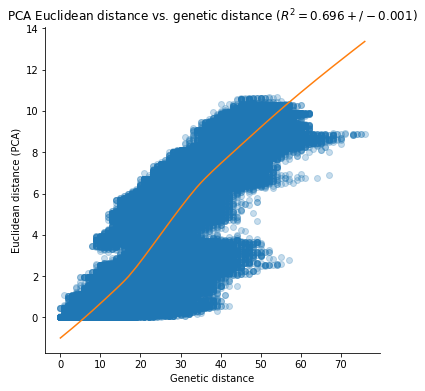

In [21]:
total_df_PCA = pd.read_csv(scatterplot_pca,index_col=0)
metadata_PCA = pd.read_csv(scatterplot_pca_metadata, index_col=0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title(f"PCA Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

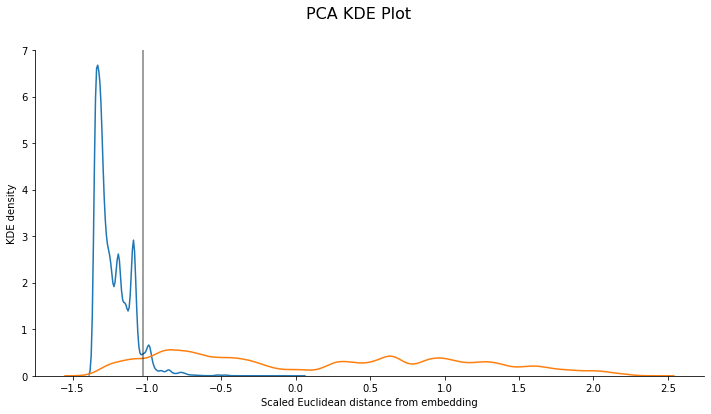

In [22]:
PCA_KDE_df = pd.read_csv(KDE_pca,index_col=0)
PCA_KDE_metadata_df = pd.read_csv(KDE_pca_metadata, index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=PCA_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('PCA KDE Plot', fontsize=16)
sns.despine()

# Running MDS on the Dataset

In [23]:
MDS_df = pd.read_csv(mds_df,index_col=0)

In [24]:
merged_mds_df = MDS_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [25]:
merged_mds_df

strain       mds1      mds2       mds3       mds4  \
0           A/Alabama/20/2017  18.977642 -0.572897   2.421951 -10.997830   
1           A/Brisbane/1/2017  18.993810  0.278117   2.645904 -12.560332   
2           A/NewYork/88/2016  18.624932 -0.127514   2.950911 -12.086349   
3           A/NewYork/99/2016  18.045875  0.773539   2.406129 -13.070893   
4       A/Washington/289/2017  18.141469  0.365109   2.211602 -12.252616   
...                       ...        ...       ...        ...        ...   
1144     A/India/1736023/2017  -3.098309 -5.600465 -16.918797   4.951125   
1145     A/HongKong/3391/2017  16.924097  4.378559  -2.795594  -2.478939   
1146         A/Kenya/013/2017 -10.559669 -2.992636  -8.874910  16.924039   
1147      A/Keelung/0023/2016   2.122133  0.151047   9.819374 -10.578167   
1148  A/MUWRP-Uganda/579/2016  19.965989  3.878731   1.507589 -17.509036   

           mds5       mds6      mds7       mds8       mds9      mds10  \
0     15.481121  16.358408  5.435225   1.338728 -25.726731  11.044589   
1     14.587145  12.966931  2.431520   2.122450 -21.418881  10.712964   
2     13.779707  12.798405  1.848802   2.339338 -21.223111   9.746386   
3     13.500025  14.014281  1.859755   3.287545 -22.151445   9.155446   
4     13.811752  14.675569  2.309219   3.273076 -23.588832   9.480620   
...         ...        ...       ...        ...        ...        ...   
1144  11.183889  -9.358526 -8.320560   2.531532   0.893764 -10.618840   
1145 -12.223688  -2.708037  2.646870   4.300610  -2.882895   7.324545   
1146  15.777779  -7.440266 -6.865349  -0.564332   8.638332   9.408819   
1147 -11.720839  -5.102204 -3.490567   4.753809   4.615495  -6.181015   
1148   6.903662   8.665535  3.626675 -16.775610   3.219827  21.672538   

      mds_label     date     y clade_membership clade_membership_color  
0             0  2017.34    18            3c3.A                  3c3.A  
1             0  2017.00    15            3c3.A                  3c3.A  
2             0  2016.57    13            3c3.A                  3c3.A  
3             0  2016.73    16            3c3.A                  3c3.A  
4             0  2017.26    22            3c3.A                  3c3.A  
...         ...      ...   ...              ...                    ...  
1144         -1  2017.79   969         A1b/135K               A1b/135K  
1145         -1  2017.52   254               A3                     A3  
1146         -1  2017.19  1059              A1b                  other  
1147         -1  2016.02   272            3c2.A                  other  
1148         -1  2016.67     2              3c3                  other  

[1149 rows x 16 columns]

In [26]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','clade_membership'],'clade_membership:N')
chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds3','mds4',"mds3","mds4",['strain','clade_membership'],'clade_membership_color')
chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds5','mds6',"mds5","mds6",['strain','clade_membership'],'clade_membership_color')
chart_12_mds|chart_34_mds|chart_56_mds

alt.HConcatChart(...)

In [27]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]

alt.HConcatChart(...)

# HDBSCAN output:

In [28]:
list_of_chart = linking_tree_with_plots_clickable(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'mds_label:N', ["mds_label"], ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

alt.HConcatChart(...)

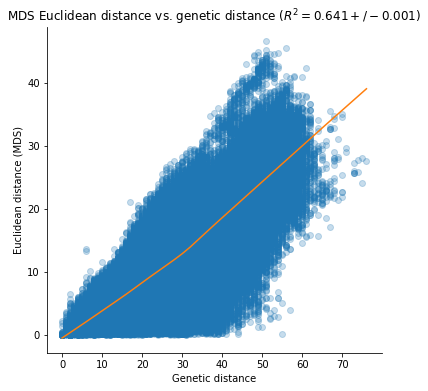

In [29]:
total_df_MDS = pd.read_csv(scatterplot_mds,index_col=0)
metadata_MDS = pd.read_csv(scatterplot_mds_metadata, index_col=0)

mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (MDS)")
ax.set_title(f"MDS Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

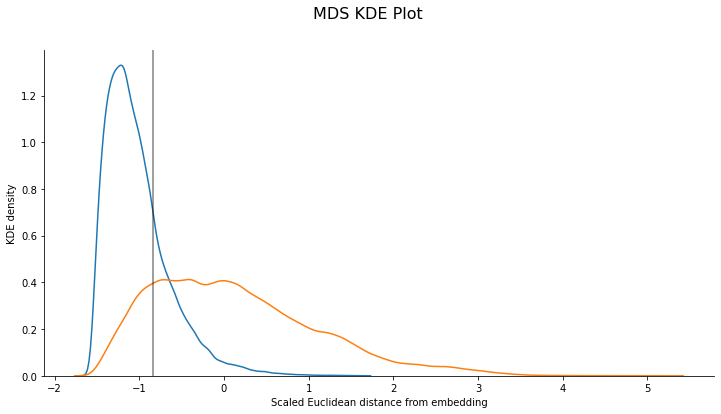

In [30]:
MDS_KDE_df = pd.read_csv(KDE_mds,index_col=0)
MDS_KDE_metadata_df = pd.read_csv(KDE_mds_metadata, index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=MDS_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('MDS KDE Plot', fontsize=16)
sns.despine()

# Running T-SNE on the Dataset 

In [32]:
TSNE_df = node_df[["strain", "date", "y", "clade_membership", "tsne_x", "tsne_y"]]

In [33]:
scatterplot_with_tooltip_interactive(TSNE_df,'tsne_x','tsne_y','tsne_x','tsne_y',['strain', "clade_membership"],'clade_membership:N')

alt.Chart(...)

In [39]:
list_of_chart = linking_tree_with_plots_brush(
    TSNE_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership:N',
    ["strain:N"]
)
chart_tsne = list_of_chart[0]|list_of_chart[1]
chart_tsne

alt.HConcatChart(...)

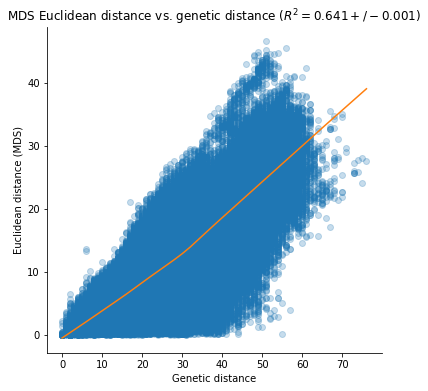

In [29]:
total_df_TSNE = pd.read_csv(scatterplot_tsne,index_col=0)
metadata_TSNE = pd.read_csv(scatterplot_tsne_metadata, index_col=0)

mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (t-SNE)")
ax.set_title(f"t-SNE Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

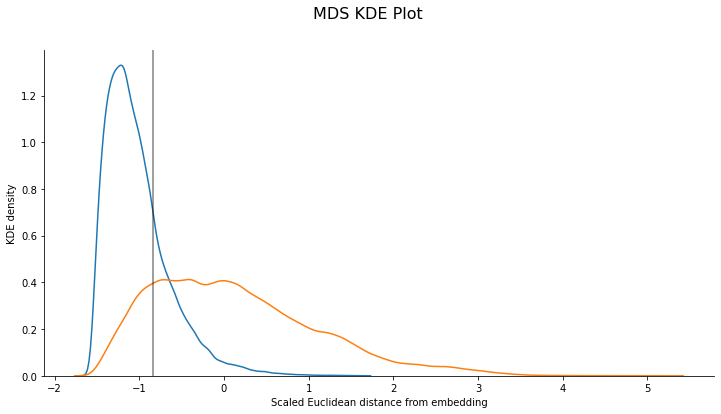

In [30]:
TSNE_KDE_df = pd.read_csv(KDE_tsne,index_col=0)
TSNE_KDE_metadata_df = pd.read_csv(KDE_tsne_metadata, index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=TSNE_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('t-SNE KDE Plot', fontsize=16)
sns.despine()

# Running UMAP on the Dataset

In [35]:
UMAP_df = node_df[["strain", "date", "y", "clade_membership", "umap_x", "umap_y"]]

In [36]:
scatterplot_with_tooltip_interactive(UMAP_df,'umap_x','umap_y','umap_x','umap_y',['strain'],'clade_membership:N')

alt.Chart(...)

In [38]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    UMAP_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership:N',
    ["strain:N"]
)
chart_umap = list_of_chart[0]|list_of_chart[1]
chart_umap
#chart.save("../docs/UMAPMERSBrush.html")

alt.HConcatChart(...)

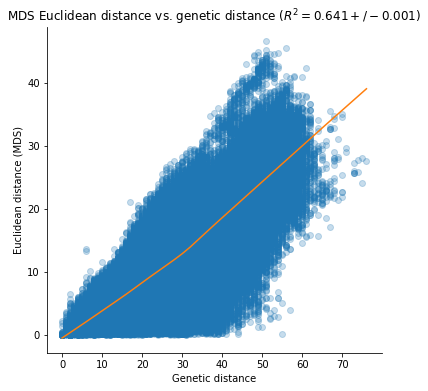

In [29]:
total_df_UMAP = pd.read_csv(scatterplot_umap,index_col=0)
metadata_UMAP = pd.read_csv(scatterplot_umap_metadata, index_col=0)

mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (UMAP)")
ax.set_title(f"UMAP Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

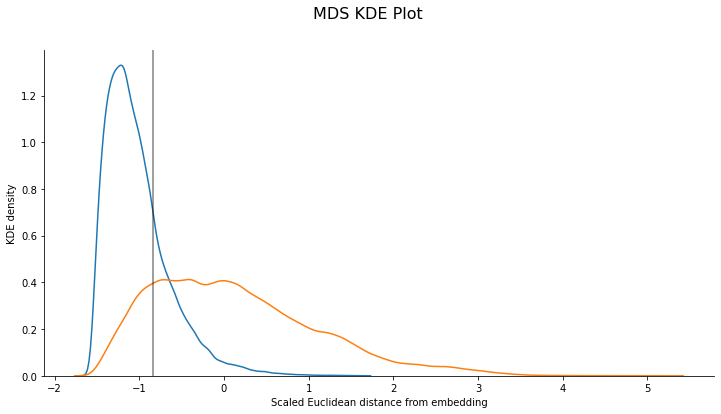

In [30]:
UMAP_KDE_df = pd.read_csv(KDE_umap,index_col=0)
UMAP_KDE_metadata_df = pd.read_csv(KDE_umap_metadata, index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=UMAP_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('UMAP KDE Plot', fontsize=16)
sns.despine()

# Linking all plots together clickable with Tree

In [42]:
data = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership:N',
    ['strain']
)

In [43]:
PCAMDS = data[3]|data[1]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.hconcat(data[0],embeddings)
fullChart
fullChart.save(snakemake.output.fullChart)

#fullChart.save("docs/FullLinkedChartClickable" + virus_name + ".svg", scale_factor=2.0)
#drawing = svg2rlg("docs/FullLinkedChartClickable" + virus_name + ".svg")
#renderPDF.drawToFile(drawing, "docs/FullLinkedChartClickable" + virus_name + ".pdf")

alt.HConcatChart(...)

## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

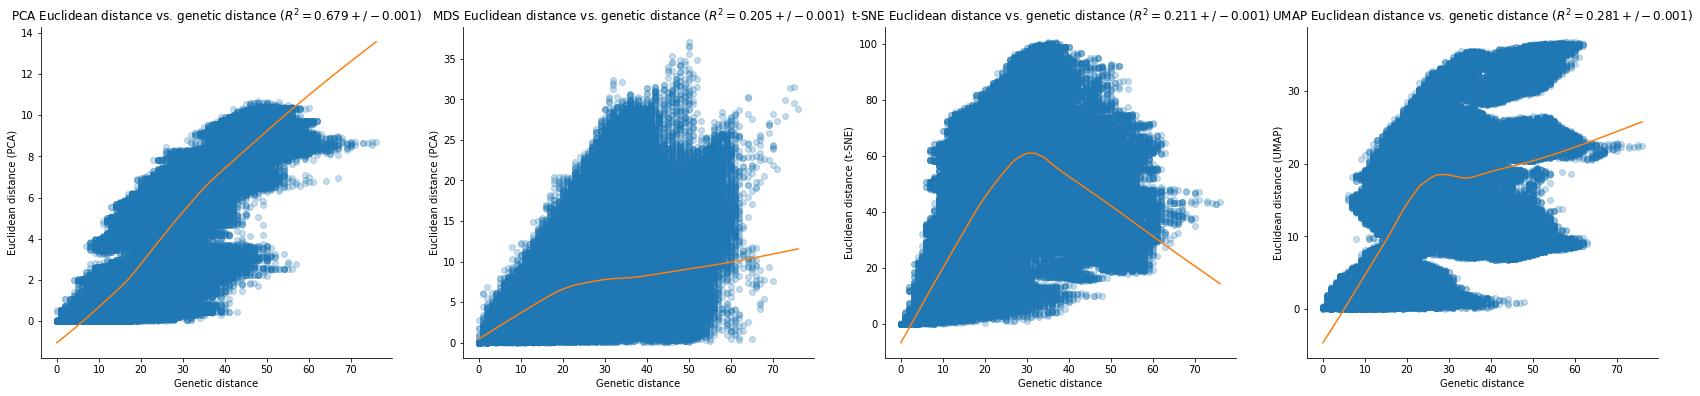

In [126]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.tight_layout(pad=4.0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title(f"PCA Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (PCA)")
ax2.set_title(f"MDS Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title(f"t-SNE Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")



mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title(f"UMAP Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


sns.despine()
plt.savefig(snakemake.output.Scatterplot)

## Within- and between-clade Euclidean distances for all embeddings

Use the complete embedding data frame to calculate pairwise Euclidean distances between samples and plot the results in a single figure.

In [127]:
Genetic_KDE_df = pd.read_csv(KDE_genetic,index_col=0)
Genetic_KDE_metadata_df = pd.read_csv(KDE_genetic_metadata, index_col=0)

In [128]:
import matplotlib.gridspec as gridspec

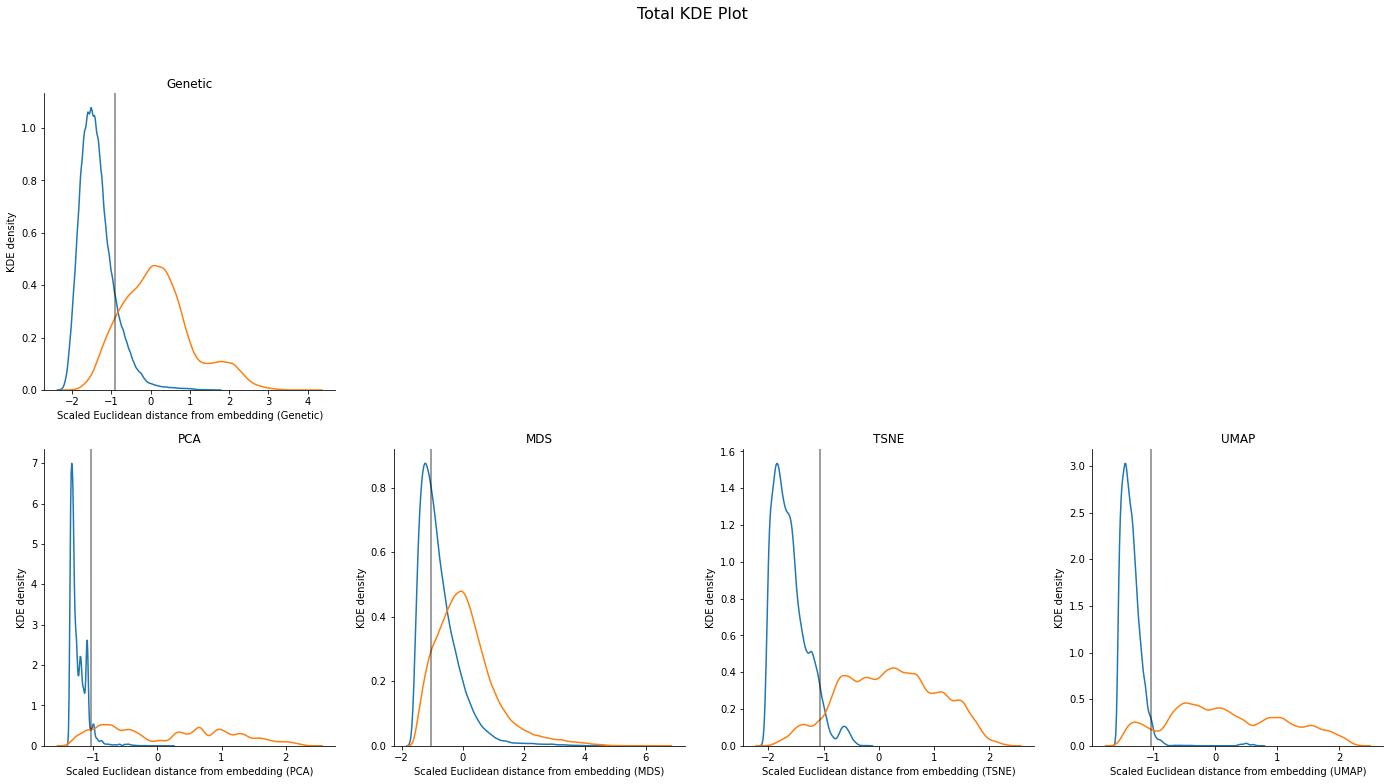

In [131]:
#fig, axes = plt.subplots(1, 5, figsize=(40, 8))
fig = plt.figure(figsize=(24, 12), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])



#GENETIC 
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax1)
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax1)
ax1.axvline(x=Genetic_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax1.set_title('Genetic')
ax1.set_xlabel("Scaled Euclidean distance from embedding (Genetic)")
ax1.set_ylabel("KDE density")

#PCA
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax2)
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax2)
ax2.axvline(x=PCA_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax2.set_title('PCA')
ax2.set_xlabel("Scaled Euclidean distance from embedding (PCA)")
ax2.set_ylabel("KDE density")

#MDS
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax3)
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax3)
ax3.axvline(x=MDS_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax3.set_title('MDS')
ax3.set_xlabel("Scaled Euclidean distance from embedding (MDS)")
ax3.set_ylabel("KDE density")

#TSNE
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax4)
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax4)
ax4.axvline(x=TSNE_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax4.set_title('TSNE')
ax4.set_xlabel("Scaled Euclidean distance from embedding (TSNE)")
ax4.set_ylabel("KDE density")

#UMAP
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax5)
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax5)
ax5.axvline(x=UMAP_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax5.set_title('UMAP')
ax5.set_xlabel("Scaled Euclidean distance from embedding (UMAP)")
ax5.set_ylabel("KDE density")


fig.suptitle('Total KDE Plot', fontsize=16)
sns.despine()
plt.savefig(snakemake.output.KDE_density)

# Supplemental Figures

In [45]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds' + str(i) for i in range(1,11)],['MDS' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'])
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]

chart.save(snakemake.output.MDS_Supplement)

In [46]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca' + str(i) for i in range(1,11)],['PCA' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'])
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]

chart.save(snakemake.output.PCA_Supplement)